In [1]:
## Here we look at the best model : Decision Tree with Monthly Data
## But to do that we need to figure out: 
## How much data is sufficient to reach a conclusion on model perforamance
# First to import relevant libraries and modules that will be used 
import numpy as np 
import pandas as pd
import random
from random import sample

#For visualization 
import matplotlib.pyplot as plt  
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

#For statistics
import math
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 

# The different algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier 

# Import the slearn utility to compare algorithms
from sklearn import model_selection,discriminant_analysis
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV



## Data Size VS Model Performance

### 1. Importing Data

In [3]:
#Importing response files 
response_data = pd.read_csv('Retail_Data_Response.csv')
response_data['response'].value_counts()
#imbalanced dataset 0-6237 and 1-647

0    6237
1     647
Name: response, dtype: int64

In [4]:
# Monthly Data
mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
days_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')

# Organising data 
mth_rolling_features1 = mth_rolling_features.drop(['Unnamed: 0'], axis = 1)
mth_day_counts = mth_day_counts.sort_values(by = ['CLNT_NO','ME_DT'])
mth_day_counts1 = mth_day_counts.drop(['Unnamed: 0'], axis = 1)
days_since_last_txn1 = days_since_last_txn.drop(['Unnamed: 0'], axis =1)

# Changing column name in response data to make merging easy 
response_data1 = response_data.rename(columns = {'customer_id':'CLNT_NO'})

monthly_features_outputs = mth_rolling_features1.merge(mth_day_counts1)
monthly_features_outputs = monthly_features_outputs.merge(days_since_last_txn1)
monthly_features_outputs = monthly_features_outputs.merge(response_data1)
monthly_features_outputs = monthly_features_outputs.fillna(0)
monthly_features_outputs


,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,CS1112,2011-05-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,0,100,0
1,CS1112,2011-06-30,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,1,15,0
2,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,46,0
3,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,...,0.0,1,0,0,0,0,0,0,12,0
4,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845995,CS5111,2015-03-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,82,1
845996,CS5111,2015-03-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,82,1
845997,CS5111,2015-03-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,82,1
845998,CS5111,2015-03-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,82,1


In [5]:
# Separating X and y values, Monthly data
y_monthly = monthly_features_outputs['response'].values

# Dropping strings i.e Client No and Dates and response
X_monthly = monthly_features_outputs.drop(['response','ME_DT','CLNT_NO'], axis = 1).values

# Monthly train test data 
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size= 1/10, random_state=1147)

# Making them into dataframes to easily manage them 
X_train_monthly = pd.DataFrame(X_train_monthly, columns =monthly_features_outputs.columns[2:30])
X_test_monthly = pd.DataFrame(X_test_monthly, columns = monthly_features_outputs.columns[2:30] )
y_train_monthly = pd.DataFrame(y_train_monthly, columns = ['response'])
y_test_monthly  = pd.DataFrame(y_test_monthly, columns = ['response'] )


In [ ]:

# Further improvement of model by increasing parameters 
param_grid = [ {'max_depth': range(1,20), 'min_samples_split' : [2,3,4,5,6,7,8,9,10] }]

decision_tree = RandomForestClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv = 5,
                          scoring = 'neg_mean_squared_error')

grid_search.fit(X_train_monthly,y_train_monthly)


/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/portiamasibi/opt/anaconda3/lib/python3.8/site-packages/sklearn/mod

In [ ]:
#GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
   #          param_grid=[{'max_depth': range(1, 20),
    #                      'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}],
   #          scoring='neg_mean_squared_error')

In [7]:
# Best parameters
decision_tree = DecisionTreeClassifier()
print('Therefore the parameters we will use are:',grid_search.best_params_)
# Therefore the parameters we will use are: {'max_depth': 19, 'min_samples_split': 2}


Therefore the parameters we will use are: {'max_depth': 19, 'min_samples_split': 2}


In [29]:
#!pip install imblearn

In [8]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler()
X_res, y_res = under_sampler.fit_resample(X_train_monthly, y_train_monthly)


### 2. Sample Size VS Test AUC

#### N samples = 50 


In [9]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 50
auc_test = []
sample_number = []

for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_50 = pd.DataFrame(table_results)
print('\n')
print('N = 50 Samples')
table_50




N = 50 Samples


,Sample #,Test AUC
0,1,0.500755
1,2,0.499765
2,3,0.511939
3,4,0.509397
4,5,0.500652
5,6,0.494747
6,7,0.523465
7,8,0.508450
8,9,0.500521
9,10,0.488272


#### N samples = 100

In [10]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 100
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_100 = pd.DataFrame(table_results)
print('\n')
print('N = 100 Samples')
table_100




N = 100 Samples


,Sample #,Test AUC
0,1,0.499469
1,2,0.506315
2,3,0.514783
3,4,0.517526
4,5,0.503073
5,6,0.513228
6,7,0.514815
7,8,0.502134
8,9,0.505432
9,10,0.506874


#### N samples = 500

In [11]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 500
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_500 = pd.DataFrame(table_results)
print('\n')
print('N = 500 Samples')
table_500




N = 500 Samples


,Sample #,Test AUC
0,1,0.519860
1,2,0.514483
2,3,0.523784
3,4,0.510368
4,5,0.518494
5,6,0.519939
6,7,0.522215
7,8,0.525823
8,9,0.509852
9,10,0.516496


#### N samples = 1000

In [12]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 1000
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_1000 = pd.DataFrame(table_results)
print('\n')
print('N = 1000 Samples')
table_1000




N = 1000 Samples


,Sample #,Test AUC
0,1,0.516670
1,2,0.529500
2,3,0.523064
3,4,0.523703
4,5,0.520561
5,6,0.530175
6,7,0.512931
7,8,0.525879
8,9,0.516272
9,10,0.497981


#### N samples = 2000

In [13]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 2000
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_2000 = pd.DataFrame(table_results)
print('\n')
print('N = 2000 Samples')
table_2000




N = 2000 Samples


,Sample #,Test AUC
0,1,0.534790
1,2,0.525229
2,3,0.534333
3,4,0.530901
4,5,0.533078
5,6,0.517232
6,7,0.528936
7,8,0.532930
8,9,0.530873
9,10,0.531897


#### N samples = 5000

In [14]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 5000
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_5000 = pd.DataFrame(table_results)
print('\n')
print('N = 5000 Samples')
table_5000




N = 5000 Samples


,Sample #,Test AUC
0,1,0.538845
1,2,0.541452
2,3,0.538108
3,4,0.538828
4,5,0.543888
5,6,0.540733
6,7,0.534422
7,8,0.539985
8,9,0.542581
9,10,0.534992


#### N samples = 10 000

In [15]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 10000
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_10000 = pd.DataFrame(table_results)
print('\n')
print('N = 10000 Samples')
table_10000




N = 10000 Samples


,Sample #,Test AUC
0,1,0.548096
1,2,0.545564
2,3,0.551418
3,4,0.549728
4,5,0.539259
5,6,0.549647
6,7,0.544613
7,8,0.546496
8,9,0.547663
9,10,0.543718


### 3. Summary of Results

In [16]:
data_size_vs_performance = pd.DataFrame()
data_size_vs_performance['Sample size N'] = [50,100, 500, 1000, 2000, 5000, 10000]
data_size_vs_performance['Test AUC Mean'] = [table_50['Test AUC'].mean(),table_100['Test AUC'].mean(),table_500['Test AUC'].mean(),table_1000['Test AUC'].mean(),table_2000['Test AUC'].mean(),table_5000['Test AUC'].mean(),table_10000['Test AUC'].mean()]
data_size_vs_performance['Test AUC Standard Deviation'] = [table_50['Test AUC'].std(),table_100['Test AUC'].std(),table_500['Test AUC'].std(),table_1000['Test AUC'].std(),table_2000['Test AUC'].std(),table_5000['Test AUC'].std(),table_10000['Test AUC'].std()]
data_size_vs_performance


,Sample size N,Test AUC Mean,Test AUC Standard Deviation
0,50,0.503796,0.009861
1,100,0.508365,0.006248
2,500,0.518131,0.005364
3,1000,0.519674,0.009490
4,2000,0.530020,0.005290
5,5000,0.539384,0.003039
6,10000,0.546620,0.003541


### 4. Errorbar Plot

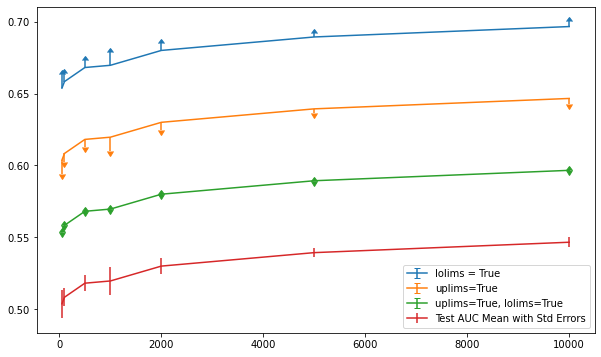

In [17]:

fig = plt.figure(figsize = (10,6))
x = data_size_vs_performance['Sample size N']
y = data_size_vs_performance['Test AUC Mean']
err =data_size_vs_performance['Test AUC Standard Deviation']


plt.errorbar(x, y + 0.15, yerr=err, lolims = True, label='lolims = True')

plt.errorbar(x, y + 0.1, yerr=err, uplims=True, label='uplims=True')

plt.errorbar(x, y + 0.05, yerr=err, uplims=True, lolims=True,
             label='uplims=True, lolims=True')

upperlimits = [True, False] * 5
lowerlimits = [False, True] * 5
plt.errorbar(x, y, yerr = err, label = 'Test AUC Mean with Std Errors')

plt.legend(loc='lower right')

#### Note: As the sample size increases, the Mean Test AUC increases and the            standard deviation decreases, therefore the higher the sample size the better.
#### The minimum number of samples required for the model to behave adequately is approximately 2000 as the mean stops sharply increasing but decreases at a slow rate, even when compared to 10 000 samples the difference is only ~0.2. 

In [ ]:

# # 2.8  Plotting decision boundary for top 2 features.


# # The importances with the highest values are "ann_txn_amt_sum_2012" and "ann_txn_amt_sum_2013" 

# # Limits: Max @ "ann_txn_sum_2012": 1242 and "ann_txn_sum_2013: 1317" 
# f1_max = math.ceil(X_train_annual.max(axis=0)[1] )
# f2_max = math.ceil(X_train_annual.max(axis=0)[2] )

# # Limits: Min @ "ann_txn_sum_2012": 0 and "ann_txn_sum_2013: 0" 
# f1_min = math.floor(X_train_annual.min(axis=0)[1])
# f2_min = math.floor(X_train_annual.min(axis=0)[2])


# #Creating a 10x10 grid between the min and max values that we will use to estimate the probabilities for the contour plot.
# xx, yy = np.mgrid[f1_min:f1_max:(f1_max-f1_min)/10, f2_min:f2_max:(f2_max-f2_min)/10] # A 10x10 grid is created
# grid = np.c_[xx.ravel(), yy.ravel()]
# print(grid.shape) # Confirm that grid shape is 10x10

# # np.ones is a table full of ones with 100x75 dimension
# # np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
# median_inputs = np.ones((100, 75)) * np.median(X_train_annual, axis=0) 
# pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# # Then, we replace the 39th and 68th column with the values of the grid
# median_inputs[:,1] = grid[:,0]
# median_inputs[:,2] = grid[:,1]
# df = pd.DataFrame(median_inputs).iloc[:12,0:5] # Convert to pandas is not necessary. 
# df.style.apply(lambda x: ['background: grey' if (x.name == 1)|(x.name == 2)  else '' for i in x])

# probs =  dtc_best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

# f, ax = plt.subplots(figsize=(8, 6))
# contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
#                       vmin=0, vmax=1)
# ax_c = f.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# #ax_c.set_ticks([0, .25, .5, .75, 1])

# ax.scatter(X_train_annual[:,1], X_train_annual[:, 2], c=y_train_annual, s=50,cmap="RdBu", vmin=-.2, vmax=1.2,
#            edgecolor="white", linewidth=1)

# ax.set(aspect="auto",
#        xlim=(0, 1120), ylim=(0, 1190),
#        xlabel="ann_txn_amt_sum_2012", ylabel="ann_txn_amt_sum_2013")
    
# plt.show() 






# # 2.8  Plotting decision boundary for top 2 features.


# # The importances with the highest values are "ann_txn_amt_sum_2012" and "cnt_Tuesday" 

# #Limits: Max @ "txn_cnt_max_6M" :6 and @ "amt_sum_12M" :3
# f1_max = math.ceil(X_train_monthly.max(axis=0)[13] )
# f2_max = math.ceil(X_train_monthly.max(axis=0)[25] )

# # Limits: Min @ "txn_cnt_max_6M": 0 and "cnt_Tuesday": 0
# f1_min = math.floor(X_train_monthly.min(axis=0)[13])
# f2_min = math.floor(X_train_monthly.min(axis=0)[25])


# #Creating a 10x10 grid between the min and max values that we will use to estimate the probabilities for the contour plot.
# xx, yy = np.mgrid[f1_min:f1_max:(f1_max-f1_min)/10, f2_min:f2_max:(f2_max-f2_min)/10] # A 10x10 grid is created
# grid = np.c_[xx.ravel(), yy.ravel()]
# print(grid.shape) # Confirm that grid shape is 10x10

# # np.ones is a table full of ones with 100x28 dimension
# # np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
# median_inputs = np.ones((100, 28)) * np.median(X_train_monthly, axis=0) 
# pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# # Then, we replace the 39th and 68th column with the values of the grid
# median_inputs[:,13] = grid[:,0]
# median_inputs[:,25] = grid[:,1]
# df = pd.DataFrame(median_inputs).iloc[:12,10:26] # Convert to pandas is not necessary. 
# df.style.apply(lambda x: ['background: grey' if (x.name == 13)|(x.name == 25)  else '' for i in x])

# probs =  dtc_best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

# f, ax = plt.subplots(figsize=(8, 6))
# contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
#                       vmin=0, vmax=1)
# ax_c = f.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# #ax_c.set_ticks([0, .25, .5, .75, 1])

# ax.scatter(X_train_monthly[:,13], X_train_monthly[:, 25], c=y_train_monthly, s=50,cmap="RdBu", vmin=-.2, vmax=1.2,
#            edgecolor="white", linewidth=1)

# ax.set(aspect="auto",
#        xlim=(0, 5.4), ylim=(0, 2.5),
#        xlabel="txn_cnt_mean_6M", ylabel="cnt_Tuesday")
    
# plt.show()  


# Plotting decision boundary for top 2 features.


# # The importances with the highest values are "ann_txn_amt_sum_2013" and "ann_txn_cnt_2013 " 

# # Limits: Max @ "ann_txn_amt_sum_2013": 1317 and "ann_txn_cnt_2013 : 17" 

# f1_max = math.ceil(X_train_annual.max(axis=0)[2] )
# f2_max = math.ceil(X_train_annual.max(axis=0)[37] )

# # Limits: Min @ "ann_txn_amt_sum_2013": 0 and "ann_txn_cnt_2013 : 0" 
# f1_min = math.floor(X_train_annual.min(axis=0)[2])
# f2_min = math.floor(X_train_annual.min(axis=0)[37])


# #Creating a 10x10 grid between the min and max values that we will use to estimate the probabilities for the contour plot.
# xx, yy = np.mgrid[f1_min:f1_max:(f1_max-f1_min)/10, f2_min:f2_max:(f2_max-f2_min)/10] # A 10x10 grid is created
# grid = np.c_[xx.ravel(), yy.ravel()]
# print(grid.shape) # Confirm that grid shape is 10x10

# # np.ones is a table full of ones with 100x75 dimension
# # np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
# median_inputs = np.ones((100, 75)) * np.median(X_train_annual, axis=0) 
# pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# # Then, we replace the 39th and 68th column with the values of the grid
# median_inputs[:,2] = grid[:,0]
# median_inputs[:,37] = grid[:,1]
# df = pd.DataFrame(median_inputs).iloc[:12,0:40] # Convert to pandas is not necessary. 
# df.style.apply(lambda x: ['background: grey' if (x.name == 2)|(x.name == 37)  else '' for i in x])

# probs =  dtc_best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

# f, ax = plt.subplots(figsize=(8, 6))
# contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
#                       vmin=0, vmax=1)
# ax_c = f.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# #ax_c.set_ticks([0, .25, .5, .75, 1])

# ax.scatter(X_train_annual[:,2], X_train_annual[:, 37], c=y_train_annual, s=50,cmap="RdBu", vmin=-.2, vmax=1.2,
#            edgecolor="white", linewidth=1)

# ax.set(aspect="auto",
#        xlim=(0, 1150), ylim=(0, 15),
#        xlabel="ann_txn_amt_sum_2013", ylabel="ann_txn_cnt_2013 ")
    
# plt.show() 


# # 2.8  Plotting decision boundary for top 2 features.


# # The importances with the highest values are "txn_cnt_mean_6M" and "txn_cnt_max_6M " 

# #Limits: Max @ "txn_cnt_mean_6M" :2.17 and @ "txn_cnt_max_6M" :6
# f1_max = math.ceil(X_train_monthly.max(axis=0)[12] )
# f2_max = math.ceil(X_train_monthly.max(axis=0)[13] )

# # Limits: Min @ "txn_cnt_mean_6M": 0 and "txn_cnt_max_6M": 0
# f1_min = math.floor(X_train_monthly.min(axis=0)[12])
# f2_min = math.floor(X_train_monthly.min(axis=0)[13])


# #Creating a 10x10 grid between the min and max values that we will use to estimate the probabilities for the contour plot.
# xx, yy = np.mgrid[f1_min:f1_max:(f1_max-f1_min)/10, f2_min:f2_max:(f2_max-f2_min)/10] # A 10x10 grid is created
# grid = np.c_[xx.ravel(), yy.ravel()]
# print(grid.shape) # Confirm that grid shape is 10x10

# # np.ones is a table full of ones with 100x28 dimension
# # np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
# median_inputs = np.ones((100, 28)) * np.median(X_train_monthly, axis=0) 
# pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# # Then, we replace the 39th and 68th column with the values of the grid
# median_inputs[:,12] = grid[:,0]
# median_inputs[:,13] = grid[:,1]
# df = pd.DataFrame(median_inputs).iloc[:12,10:15] # Convert to pandas is not necessary. 
# df.style.apply(lambda x: ['background: grey' if (x.name == 12)|(x.name == 13)  else '' for i in x])

# probs =  dtc_best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

# f, ax = plt.subplots(figsize=(8, 6))
# contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
#                       vmin=0, vmax=1)
# ax_c = f.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# #x_c.set_ticks([0, .25, .5, .75, 1])

# ax.scatter(X_train_monthly[:,12], X_train_monthly[:, 13], c=y_train_monthly, s=50,cmap="RdBu", vmin=-.2, vmax=1.2,
#            edgecolor="white", linewidth=1)

# ax.set(aspect="auto",
#        xlim=(0, 2 ), ylim=(0, 5.3),
#        xlabel="txn_cnt_mean_6M", ylabel="txn_cnt_max_6M")
# plt.show()


